<h1>Generating a Circuit for Hamiltonian Simulation Using QSP</h1>

<h2> Distribution Statement </h2>

DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

<br>
This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

<br>
© 2022 Massachusetts Institute of Technology.

<br>
<br>
The software/firmware is provided to you on an As-Is basis

<br>
<br>
Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.

This notebook describes a method for generating a quantum circuit for Hamiltonian simulation using the Quantum Signal Processing (QSP) algorithm.

The user of this notebook must know the following values:

- Hamiltoian of the problem to simulate
- Requested precision of circuit
- Timestep where simulation occurs

__Note:__ This notebook will generate a single circuit which corresponds to a single timestep. If multiple timesteps are desired for simulation, and one desires to maintain a precision threshold, the number of phased-iterates will necessarily change over time, resulting in different circuits. 

For additional information on QSP and formulating a Hamiltonian for use with QSP, please see accompanying notebooks.

In [17]:
###
### Imports to support the pyQSP Gate-Based Hamiltonian simulation
###
import cirq
from cirq.contrib.svg import SVGCircuit

import pyLIQTR.QSP.gen_qsp                 as qspFuncs
import pyLIQTR.QSP.QSP                     as pQSP
import pyLIQTR.model_simulators.vlasovsim  as vs        


from pyLIQTR.QSP.Hamiltonian             import Hamiltonian as pyH
from pyLIQTR.QSP.qsp_helpers             import qsp_decompose_once, print_to_openqasm, prettyprint_qsp_to_qasm # these should move to a utils.
from pyLIQTR.gate_decomp.cirq_transforms import clifford_plus_t_direct_transform


Define the Hamiltonian, required precision, and time

In [18]:
###
### User Input: Vlasov Equation Parameterization 
###

N      = 3                                     # Number of terms in the Vlasov-Hermite 
                                               # expansion (equivalent to qubits)

k      =  2.0                                  # Fourier wavenumber

nu     =  0.0                                  # Collisional damping parameter : 
                                               # (for use only with statevector propagation)
                                               # (SET TO 0 for now, since imag otherwise)

alpha  =  0.6                                  # Electric field parameter


required_precision   = 1e-2
timestep_of_interest = 0.05 # sim_time

ham_string = vs.hamiltonian_wfn_vlasov_hermite_linear_sym_string(k, alpha, nu, N)

qsp_H = pyH(ham_string)

print('\n: --- Visual Check Hamiltonian ---')
print(f': qsp_H = {qsp_H}\n')


: --- Visual Check Hamiltonian ---
: qsp_H = [('IXX', 0.8944271909999159), ('IYY', 0.8944271909999159), ('XXI', 1.0), ('YYI', 1.0)]



Calculate the angles needed for QSP

_Note:_ Calculating angles generates signifigant output to screen. Additionally, if one is not interested in actually simulating the circuit (ie, one does not care about the simulated state but is more interested in circuit structure), then one can forego generating accurate angle values and just provide randomly generated values, since the circuit structure depends only on the # of angles and not the actual value. 

In [ ]:

angles, tolerances = qspFuncs.get_phis(qsp_H, simtime=timestep_of_interest, req_prec=required_precision)

print(qspFuncs.get_phis(qsp_H, simtime=timestep_of_interest, req_prec=required_precision, steps_only=True))
print(len(angles))

This is the simplest form of the QSP circuit as implemented. Three "target" qubits corresponding to each of the qubits required to model the problem, the "phase" qubit on which rotations from the calculated angles act upon, "control" qubits which are used for implementing the Hamiltonian upon the target and phase qubits, and a minimum number of ancilla qubits for efficiently implementing the required operations. 

As the number of phased iterates increases, additional triplets of SelectV+Reflect+SelectV operations are added.

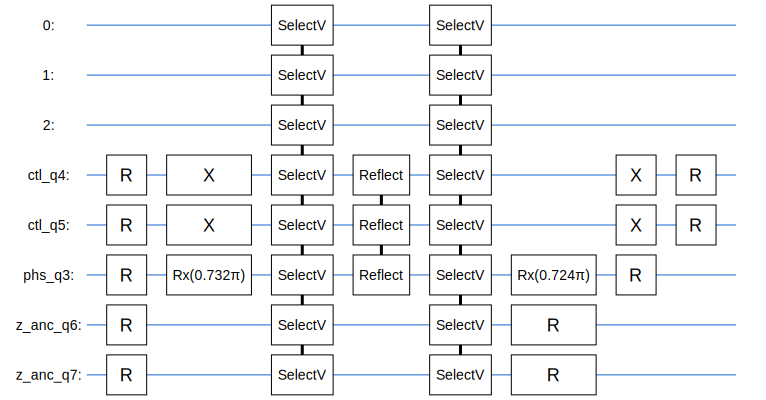

In [20]:
qsp_generator = pQSP.QSP(phis=angles, hamiltonian=qsp_H, target_size=qsp_H.problem_size)
qsp_circ      = qsp_generator.circuit()
# print(qsp_circ)

SVGCircuit(qsp_circ)

## Convert QSP circuit to gate-level and export to OpenQasm 2.0

Fully decompose the circuit from QSP operations to gates, and then visualize the Cirq circuit with all operations aligned to the 'beginning' time-wise.

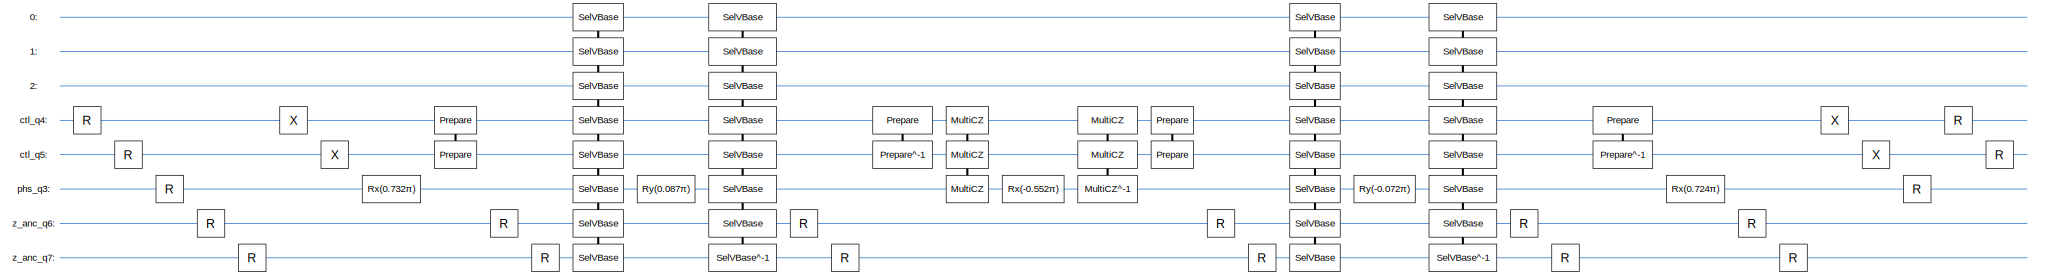

In [21]:
decomposed_once_circuit = (qsp_decompose_once(qsp_circ))
decomposed_circuit      = (qsp_decompose_once(decomposed_once_circuit))
cliff_plus_T_circuit    = clifford_plus_t_direct_transform(decomposed_circuit)


SVGCircuit(decomposed_once_circuit)
# SVGCircuit(decomposed_circuit)
# SVGCircuit(cliff_plus_T_circuit)
# print(decomposed_circuit.to_text_diagram_drawer(transpose=True).render())
# print(cliff_plus_T_circuit.to_text_diagram_drawer(transpose=True).render())

Convert the Cirq circuit to OpenQASM 2.0 format, and print to stdout

In [22]:
print_to_openqasm(sys.stdout, decomposed_circuit, qubits=decomposed_circuit.all_qubits())
# print_to_openqasm(sys.stdout, cliff_plus_T_circuit)

// Generated from Cirq v1.0.0
OPENQASM 2.0;
include "qelib1.inc";
// Qubits: [phs_q3, q(0), z_anc_q6, ctl_q5, q(2), ctl_q4, z_anc_q7, q(1)]
// Cirq -> OpenQASM Map : 'phs_q3': 'q[0]', 'q(0)': 'q[1]', 'z_anc_q6': 'q[2]', 'ctl_q5': 'q[3]', 'q(2)': 'q[4]', 'ctl_q4': 'q[5]', 'z_anc_q7': 'q[6]', 'q(1)': 'q[7]'
qreg q[8];
reset q[5];
reset q[3];
reset q[0];
reset q[2];
reset q[6];
x q[5];
x q[3];
rx(pi*0.7316736283) q[0];
ry(pi*0.5177479965) q[5];
cx q[5],q[3];
ry(0) q[3];
cx q[5],q[3];
ry(pi*0.5) q[3];
reset q[2];
reset q[6];
x q[5];
x q[3];
ccx q[0],q[5],q[2];
x q[5];
ccx q[3],q[2],q[6];
x q[3];
sdg q[1];
sdg q[7];
x q[3];
sdg q[4];
cx q[6],q[1];
s q[1];
cx q[6],q[7];
s q[7];
cx q[2],q[6];
cx q[6],q[1];
cx q[6],q[7];
cx q[2],q[6];
sdg q[7];
ccx q[0],q[3],q[6];
x q[3];
cx q[0],q[2];
cx q[6],q[7];
s q[7];
cx q[6],q[4];
s q[4];
cx q[2],q[6];
cx q[6],q[7];
cx q[6],q[4];
ccx q[3],q[2],q[6];
ccx q[0],q[5],q[2];
ry(pi*0.0869915962) q[0];
ccx q[0],q[5],q[2];
ccx q[3],q[2],q[6];
cx q[6],q[4];
cx q[

Convert the Cirq circuit to OpenQASM 2.0 format, and print to a file

In [23]:
#Write it.
with open('my_example_qasm.qasm','w') as f:
    print_to_openqasm(f, decomposed_circuit)

#Read it.
with open('my_example_qasm.qasm','r') as f:
    lines = "".join(f.readlines())
    print(lines)

#Delete it.
os.remove('my_example_qasm.qasm')

// Generated from Cirq v1.0.0
OPENQASM 2.0;
include "qelib1.inc";
// Qubits: [q(0), q(1), q(2), ctl_q4, ctl_q5, phs_q3, z_anc_q6, z_anc_q7]
// Cirq -> OpenQASM Map : 'q(0)': 'q[0]', 'q(1)': 'q[1]', 'q(2)': 'q[2]', 'ctl_q4': 'q[3]', 'ctl_q5': 'q[4]', 'phs_q3': 'q[5]', 'z_anc_q6': 'q[6]', 'z_anc_q7': 'q[7]'
qreg q[8];
reset q[3];
reset q[4];
reset q[5];
reset q[6];
reset q[7];
x q[3];
x q[4];
rx(pi*0.7316736283) q[5];
ry(pi*0.5177479965) q[3];
cx q[3],q[4];
ry(0) q[4];
cx q[3],q[4];
ry(pi*0.5) q[4];
reset q[6];
reset q[7];
x q[3];
x q[4];
ccx q[5],q[3],q[6];
x q[3];
ccx q[4],q[6],q[7];
x q[4];
sdg q[0];
sdg q[1];
x q[4];
sdg q[2];
cx q[7],q[0];
s q[0];
cx q[7],q[1];
s q[1];
cx q[6],q[7];
cx q[7],q[0];
cx q[7],q[1];
cx q[6],q[7];
sdg q[1];
ccx q[5],q[4],q[7];
x q[4];
cx q[5],q[6];
cx q[7],q[1];
s q[1];
cx q[7],q[2];
s q[2];
cx q[6],q[7];
cx q[7],q[1];
cx q[7],q[2];
ccx q[4],q[6],q[7];
ccx q[5],q[3],q[6];
ry(pi*0.0869915962) q[5];
ccx q[5],q[3],q[6];
ccx q[4],q[6],q[7];
cx q[7],q[2];
cx q[

Pretty print the qasm circuit to include comments where Phased Iterates, Select V, and Reflect operations start and end.

In [24]:
### Pretty Print the circuit to qasm:
prettyprint_qsp_to_qasm(sys.stdout, qsp_circ)

// Generated from Cirq v1.0.0
OPENQASM 2.0;
include "qelib1.inc";
// Qubits: [phs_q3, q(0), z_anc_q6, ctl_q5, q(2), ctl_q4, z_anc_q7, q(1)]
// Cirq -> OpenQASM Map : 'phs_q3': 'q[0]', 'q(0)': 'q[1]', 'z_anc_q6': 'q[2]', 'ctl_q5': 'q[3]', 'q(2)': 'q[4]', 'ctl_q4': 'q[5]', 'z_anc_q7': 'q[6]', 'q(1)': 'q[7]'
qreg q[8];
reset q[5];
reset q[3];
reset q[0];
reset q[2];
reset q[6];
x q[5];
x q[3];
rx(pi*0.7316736283) q[0];
// START PHASED_ITERATE_0
// START SELECT_V
ry(pi*0.5177479965) q[5];
cx q[5],q[3];
ry(0) q[3];
cx q[5],q[3];
ry(pi*0.5) q[3];
reset q[2];
reset q[6];
x q[5];
x q[3];
ccx q[0],q[5],q[2];
x q[5];
ccx q[3],q[2],q[6];
x q[3];
sdg q[1];
sdg q[7];
x q[3];
sdg q[4];
cx q[6],q[1];
s q[1];
cx q[6],q[7];
s q[7];
cx q[2],q[6];
cx q[6],q[1];
cx q[6],q[7];
cx q[2],q[6];
sdg q[7];
ccx q[0],q[3],q[6];
x q[3];
cx q[0],q[2];
cx q[6],q[7];
s q[7];
cx q[6],q[4];
s q[4];
cx q[2],q[6];
cx q[6],q[7];
cx q[6],q[4];
ccx q[3],q[2],q[6];
ccx q[0],q[5],q[2];
ry(pi*0.0869915962) q[0];
ccx q[0],q[5],q